고장을 7mils, 14mils, 21mils, 28mils 4가지 경우로 묶어서 나누고, 하나의 고장 그룹을 고장, 나머지를 정상으로 하여 MTS

In [3]:
import cwru                      # Case Western Reserve University Bearing Data
import pandas as pd              # dataframe
import numpy as np               # array
from collections import Counter  # Class 갯수 세기
import matplotlib.pyplot as plt  # Visualization
%matplotlib inline
from scipy.fftpack import fft, ifft
from acoustics.cepstrum import complex_cepstrum, real_cepstrum
from sklearn.preprocessing import scale
from scipy.spatial import distance
from numpy.linalg import inv

In [4]:
cwru_data = cwru.CWRU("12DriveEndFault", "1750", 12000)

In [5]:
cwru_data.labels

('0.007-Ball',
 '0.007-InnerRace',
 '0.007-OuterRace12',
 '0.007-OuterRace3',
 '0.007-OuterRace6',
 '0.014-Ball',
 '0.014-InnerRace',
 '0.014-OuterRace6',
 '0.021-Ball',
 '0.021-InnerRace',
 '0.021-OuterRace12',
 '0.021-OuterRace3',
 '0.021-OuterRace6',
 '0.028-Ball',
 '0.028-InnerRace',
 'Normal')

In [6]:
x_train = np.asarray(cwru_data.X_train)
x_test = np.asarray(cwru_data.X_test)

y_train = np.asarray(cwru_data.y_train)
y_test = np.asarray(cwru_data.y_test)

In [7]:
print(Counter(y_train)) # Train 데이터 클래스 분포
print(Counter(y_test))  # Test 데이터 클래스 분포

Counter({15: 30, 0: 7, 1: 7, 2: 7, 3: 7, 4: 7, 5: 7, 6: 7, 7: 7, 8: 7, 9: 7, 10: 7, 11: 7, 12: 7, 13: 7, 14: 7})
Counter({15: 10, 0: 3, 1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 3, 12: 3, 13: 3, 14: 3})


In [8]:
x_test.shape

(55, 12000)

In [9]:
class_15_train_idx, = np.where(y_train == 15)
class_15_test_idx, = np.where(y_test == 15)

In [10]:
# remove class 15
x_train = np.delete(x_train, class_15_train_idx, axis = 0)
x_test = np.delete(x_test, class_15_test_idx, axis = 0)

y_train = np.delete(y_train, class_15_train_idx, axis = 0)
y_test = np.delete(y_test, class_15_test_idx, axis = 0)

In [11]:
# k class is abnormal
def make_dataset(d):
    
    if d == 7:
        normal_train_idx, = np.where((y_train != 0) & (y_train != 1) & (y_train != 2) & (y_train != 3) & (y_train != 4))
        normal_test_idx, = np.where((y_test != 0) & (y_test != 1) & (y_test != 2) & (y_test != 3) & (y_test != 4))

        abnormal_train_idx, = np.where((y_train == 0) | (y_train == 1) | (y_train == 2) | (y_train == 3) | (y_train == 4))
        abnormal_test_idx, = np.where((y_test == 0) | (y_test == 1) | (y_test == 2) | (y_test == 3) | (y_test == 4))
        
    elif d == 14:
        normal_train_idx, = np.where((y_train != 5) & (y_train != 6) & (y_train != 7))
        normal_test_idx, = np.where((y_test != 5) & (y_test != 6) & (y_test != 7))

        abnormal_train_idx, = np.where((y_train == 5) | (y_train == 6) | (y_train == 7))
        abnormal_test_idx, = np.where((y_test == 5) | (y_test == 6) | (y_test == 7))
        
    elif d == 21:
        normal_train_idx, = np.where((y_train != 8) & (y_train != 9) & (y_train != 10) & (y_train != 11) & (y_train != 12))
        normal_test_idx, = np.where((y_test != 8) & (y_test != 9) & (y_test != 10) & (y_test != 11) & (y_test != 12))

        abnormal_train_idx, = np.where((y_train == 8) | (y_train == 9) | (y_train == 10) | (y_train == 11) | (y_train == 12))
        abnormal_test_idx, = np.where((y_test == 8) | (y_test == 9) | (y_test == 10) | (y_test == 11) | (y_test == 12))
        
    elif d == 28:
        normal_train_idx, = np.where((y_train != 13) & (y_train != 14))
        normal_test_idx, = np.where((y_test != 13) & (y_test != 14))

        abnormal_train_idx, = np.where((y_train == 13) | (y_train == 14))
        abnormal_test_idx, = np.where((y_test == 13) | (y_test == 14))
        
    else:
        print('Typing Error')
    
    return normal_train_idx, normal_test_idx, abnormal_train_idx, abnormal_test_idx
    

In [12]:
normal_train_idx, normal_test_idx, abnormal_train_idx, abnormal_test_idx = make_dataset(7)

for i in range(len(y_train)):
    if i in normal_train_idx:
        y_train[i] = 0 # Normal
    else:
        y_train[i] = 1 # Abnormal 

# Test 데이터 클래스 수정
for i in range(len(y_test)):
    if i in normal_test_idx:
        y_test[i] = 0
    else:
        y_test[i] = 1 
            

In [13]:
y_test

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0])

In [14]:
sum(y_train)

35

In [15]:
def do_FFT(signal_set):
    window = np.hamming(12000)
    fft_rlt = np.fft.fft(window * signal_set)
    return(fft_rlt)

def do_Cepstrum(spectrum):
    cep_result = (ifft(np.log(spectrum**2))**2).real
    return(cep_result)

    #ifft(np.log(np.abs(spectrum)))

In [16]:
#Data split
normal_x_train = pd.DataFrame(x_train[normal_train_idx])
normal_x_test = pd.DataFrame(x_test[normal_test_idx])

abnormal_x_train = pd.DataFrame(x_train[abnormal_train_idx])
abnormal_x_test = pd.DataFrame(x_test[abnormal_test_idx])

In [17]:
abnormal_x_train.shape

(35, 12000)

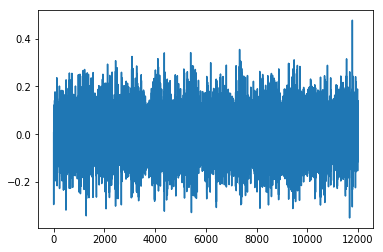

In [18]:
plt.plot(normal_x_train.iloc[0,:])

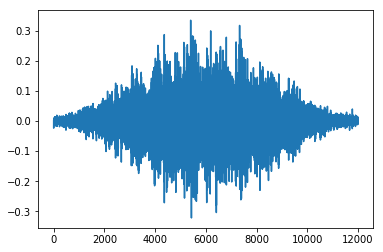

In [19]:
plt.plot(normal_x_train.iloc[0,:]*np.hamming(12000))

In [20]:
#Standardization
normal_x_train_scaled = pd.DataFrame(scale(normal_x_train, axis = 1))
normal_x_test_scaled = pd.DataFrame(scale(normal_x_test, axis = 1))

abnormal_x_train_scaled = pd.DataFrame(scale(abnormal_x_train, axis = 1))
abnormal_x_test_scaled = pd.DataFrame(scale(abnormal_x_test, axis = 1))

'''
#No-Standardization
normal_x_train_scaled = normal_x_train
normal_x_test_scaled = normal_x_test

abnormal_x_train_scaled = abnormal_x_train
abnormal_x_test_scaled = abnormal_x_test
'''

'\n#No-Standardization\nnormal_x_train_scaled = normal_x_train\nnormal_x_test_scaled = normal_x_test\n\nabnormal_x_train_scaled = abnormal_x_train\nabnormal_x_test_scaled = abnormal_x_test\n'

In [21]:
#Hamming and FFT
normal_x_train_fft = np.apply_along_axis(do_FFT, 1, normal_x_train_scaled)
normal_x_test_fft = np.apply_along_axis(do_FFT, 1, normal_x_test_scaled)

abnormal_x_train_fft = np.apply_along_axis(do_FFT, 1, abnormal_x_train_scaled)
abnormal_x_test_fft = np.apply_along_axis(do_FFT, 1, abnormal_x_test_scaled)

Text(0,0.5,'|Y(freq)|')

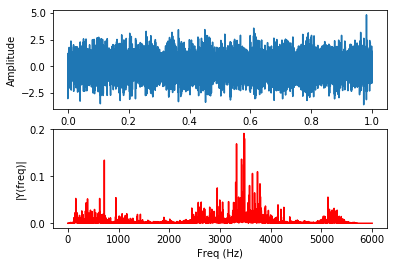

In [22]:
Fs = 12000.0;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,1,Ts) # time vector

y = normal_x_train_scaled.iloc[0,:]

n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n/2)] # one side frequency range

Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(n/2)]

fig, ax = plt.subplots(2, 1)
ax[0].plot(t,y)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')


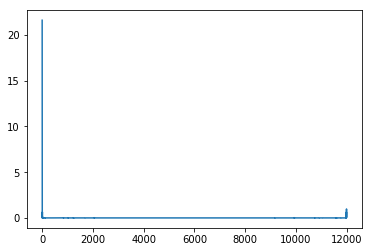

In [23]:
#Cepstrum
normal_x_train_cep = np.apply_along_axis(do_Cepstrum, 1, normal_x_train_fft)
normal_x_test_cep = np.apply_along_axis(do_Cepstrum, 1, normal_x_test_fft)

abnormal_x_train_cep = np.apply_along_axis(do_Cepstrum, 1, abnormal_x_train_fft)
abnormal_x_test_cep = np.apply_along_axis(do_Cepstrum, 1, abnormal_x_test_fft)

plt.plot(normal_x_train_cep[0])

In [24]:
#SI Functions
def get_mean(x):
    avg = np.mean(x)
    return(avg)

def get_std(x):
    std = np.std(x)
    return(std)

def get_skewness(x):
    skewness = sum((x - np.mean(x))**3) / ((len(x)-1)*(np.std(x)**3))
    return(skewness)

def get_kurtosis(x):
    kurtosis = sum((x - np.mean(x))**4) / ((len(x)-1)*(np.std(x)**4))
    return (kurtosis)

def get_p2p(x):
    p2p = (np.max(x) - np.min(x))
    return(p2p)

def get_rms(x):
    rms = np.sqrt(sum(x**2) / len(x))
    return(rms)

def get_crestFactor(x):
    crestFactor = get_p2p(x) / get_rms(x)
    return(crestFactor)

def get_shapeFactor(x):
    shapeFactor = get_rms(x) / get_mean(x)
    return(shapeFactor)
    
def get_marginFactor(x):
    marginFactor = np.max(x) / (np.mean((np.sqrt(abs(x))))**2)
    return(marginFactor)

def get_impulseFactor(x):
    impulseFactor = np.max(x) / np.mean(abs(x))
    return(impulseFactor)


In [25]:
def make_df(x):
    mean_value = np.apply_along_axis(get_mean, 1, x)
    std_value = np.apply_along_axis(get_std, 1, x)
    skewness_value = np.apply_along_axis(get_skewness, 1, x)
    kurtosis_value = np.apply_along_axis(get_kurtosis, 1, x)
    p2p_value = np.apply_along_axis(get_p2p, 1, x)
    rms_value = np.apply_along_axis(get_rms, 1, x)
    crestFactor_value = np.apply_along_axis(get_crestFactor, 1, x)
    shapeFactor_value = np.apply_along_axis(get_shapeFactor, 1, x)
    marginFactor_value = np.apply_along_axis(get_marginFactor, 1, x)
    impulseFactor_value = np.apply_along_axis(get_impulseFactor, 1, x)
    
    df = pd.DataFrame({'mean':mean_value, 'std':std_value, 'skewness':skewness_value, 'kurtosis':kurtosis_value, 'p2p':p2p_value, 'rms':rms_value,
                       'crest':crestFactor_value, 'shape':shapeFactor_value, 'margin':marginFactor_value, 'impulse':impulseFactor_value})
    
    return(df)

In [26]:
#make dataframe
normal_x_train_SI = make_df(normal_x_train_cep)
normal_x_test_SI = make_df(normal_x_test_cep)

abnormal_x_train_SI = make_df(abnormal_x_train_cep)
abnormal_x_test_SI = make_df(abnormal_x_test_cep)

In [27]:
#Standardization in MTS
def standardize(x,y):
    mean_mean = get_mean(x['mean'])
    std_mean = get_mean(x['std'])
    skewness_mean = get_mean(x['skewness'])
    kurtosis_mean = get_mean(x['kurtosis'])
    p2p_mean = get_mean(x['p2p'])
    rms_mean = get_mean(x['rms'])
    crest_mean = get_mean(x['crest'])
    shape_mean = get_mean(x['shape'])
    margin_mean = get_mean(x['margin'])
    impulse_mean = get_mean(x['impulse'])
    
    mean_std = get_std(x['mean'])
    std_std = get_std(x['std'])
    skewness_std = get_std(x['skewness'])
    kurtosis_std = get_std(x['kurtosis'])
    p2p_std = get_std(x['p2p'])
    rms_std = get_std(x['rms'])
    crest_std = get_std(x['crest'])
    shape_std = get_std(x['shape'])
    margin_std = get_std(x['margin'])
    impulse_std = get_std(x['impulse'])
    
    mean_value = (y['mean'] - mean_mean) / mean_std
    std_value = (y['std'] - std_mean) / std_std
    skewness_value = (y['skewness'] - skewness_mean) / skewness_std
    kurtosis_value = (y['kurtosis'] - kurtosis_mean) / kurtosis_std
    p2p_value = (y['p2p'] - p2p_mean) / p2p_std
    rms_value = (y['rms'] - rms_mean) / rms_std
    crest_value = (y['crest'] - crest_mean) / crest_std
    shape_value = (y['shape'] - shape_mean) / shape_std
    margin_value = (y['margin'] - margin_mean) / margin_std
    impulse_value = (y['impulse'] - impulse_mean) / impulse_std
    
    df = pd.DataFrame({'mean':mean_value, 'std':std_value, 'skewness':skewness_value, 'kurtosis':kurtosis_value, 'p2p':p2p_value, 'rms':rms_value,
                       'crest':crest_value, 'shape':shape_value, 'margin':margin_value, 'impulse':impulse_value})
    
    return(df)

In [28]:
normal_x_train_SI_scaled = standardize(normal_x_train_SI, normal_x_train_SI)
normal_x_test_SI_scaled = standardize(normal_x_train_SI, normal_x_test_SI)

abnormal_x_train_SI_scaled = standardize(normal_x_train_SI, abnormal_x_train_SI)
abnormal_x_test_SI_scaled = standardize(normal_x_train_SI, abnormal_x_test_SI)

In [29]:
def get_MD_distance(x):
    normal_cov_mat = pd.DataFrame(normal_x_train_SI_scaled).corr()
    dist = np.matmul(np.matmul(x, inv(normal_cov_mat)), np.transpose(x)) / len(x)
    return(dist)

In [48]:
normal_train_dist = np.apply_along_axis(get_MD_distance, 1, normal_x_train_SI_scaled)
normal_train_dist.sort()
normal_test_dist = np.apply_along_axis(get_MD_distance, 1, normal_x_test_SI_scaled)
normal_test_dist.sort()

abnormal_train_dist = np.apply_along_axis(get_MD_distance, 1, abnormal_x_train_SI_scaled)
abnormal_train_dist.sort()
abnormal_test_dist = np.apply_along_axis(get_MD_distance, 1, abnormal_x_test_SI_scaled)
abnormal_test_dist.sort()


In [49]:
print(normal_train_dist)
print('\n')
print(normal_test_dist)
print('\n')
print(abnormal_train_dist)
print('\n')
print(abnormal_test_dist)


[0.18189632 0.18956656 0.2709112  0.29622778 0.29731657 0.33382721
 0.33660353 0.37493525 0.37854181 0.43255883 0.43999428 0.44824793
 0.4536098  0.49568207 0.5084434  0.52477205 0.53663425 0.54448752
 0.57115061 0.5861581  0.60363901 0.6174275  0.61847004 0.62064916
 0.62095345 0.65075072 0.65808914 0.65846866 0.6764518  0.78951351
 0.79158967 0.79736551 0.80530782 0.81776035 0.81855816 0.85417676
 0.86977008 0.87855121 0.87991948 0.92142188 0.92710281 0.95630152
 0.9654924  0.9879401  0.99952971 1.01698331 1.01988043 1.02713551
 1.07254013 1.07584441 1.10799358 1.12771371 1.16199105 1.17765008
 1.21017452 1.23768251 1.27442843 1.31405044 1.32398921 1.37649719
 1.50340947 1.75547441 1.89866843 2.05371204 2.22111054 2.24420346
 2.43682364 2.81362553 3.54226587 4.01700872]


[0.12162338 0.15774301 0.16131956 0.37163426 0.40867163 0.41557085
 0.42325495 0.45323279 0.4752287  0.47856023 0.50084562 0.50664155
 0.55497081 0.61196064 0.66413357 0.69838194 0.70203152 0.82263103
 0.86568526 1.

In [33]:
#L_12(2^11) orthogonal array
ortho_array = np.matrix([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2],
                       [1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2],
                       [1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2],
                       [1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1],
                       [1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1],
                       [2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1],
                       [2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2],
                       [2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1],
                       [2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2],
                       [2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2],
                       [2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1]])

In [34]:
otho_df = pd.DataFrame(ortho_array, columns=['mean', 'std', 'skewness', 'kurtosis', 'p2p', 'rms', 'crest', 'shape', 'margin', 'impulse','DUMMY'])

In [35]:
def get_exp_col(n):
    condition = otho_df.iloc[n,:]==1
    col = list(otho_df.loc[n,condition].index)
    if('DUMMY' in col):
        col.pop()
    return(col)

In [36]:
def get_MD_distance_exp(x,n):
    col = get_exp_col(n)
    normal_cov_mat = pd.DataFrame(normal_x_train_SI_scaled[col]).corr()
    dist = np.matmul(np.matmul(x, inv(normal_cov_mat)), np.transpose(x)) / len(x)
    return(dist)

In [37]:
def get_MD_exp(n,df):
    col = get_exp_col(n)
    target_df = df[col]
    dist = np.apply_along_axis(get_MD_distance_exp, 1, target_df, n)
    return(dist)

In [38]:
def get_MD_matrix(df):
    arr = np.empty([12, df.shape[0]])
    for i in range(0,12):
        arr[i,:] = get_MD_exp(i,df)
        
    return(arr)

In [39]:
normal_x_test_MD_matrix = get_MD_matrix(normal_x_test_SI_scaled)

abnormal_x_train_MD_matrix = get_MD_matrix(abnormal_x_train_SI_scaled)
abnormal_x_test_MD_matrix = get_MD_matrix(abnormal_x_test_SI_scaled)


In [40]:
def cal_larger_better_SNRatio(mat):
    SNRatio = []
    for i in range(0,mat.shape[0]):
        dist = mat[i]
        SN = -10 * np.log10(np.mean(1/(dist)))
        SNRatio.append(SN)
        
    return(SNRatio)

In [41]:
def cal_smaller_better_SNRatio(mat):
    SNRatio = []
    for i in range(0,mat.shape[0]):
        dist = mat[i]
        SN = -10 * np.log10(np.mean(dist))
        SNRatio.append(SN)
        
    return(SNRatio)

In [42]:
SNRatio_normal_test = cal_smaller_better_SNRatio(normal_x_test_MD_matrix)

SNRatio_abnormal_train = cal_larger_better_SNRatio(abnormal_x_train_MD_matrix)
SNRatio_abnormal_test = cal_larger_better_SNRatio(abnormal_x_test_MD_matrix)

In [43]:
def cal_smaller_better_gain(mat,col_name):
    idx_1 = list(otho_df.loc[otho_df[col_name] == 1].index)
    idx_2 = list(otho_df.loc[otho_df[col_name] == 2].index)
    
    SN = np.array(cal_smaller_better_SNRatio(mat))
    values_1 = np.mean(SN[idx_1])
    values_2 = np.mean(SN[idx_2])
    
    gain = values_1 - values_2
    
    return(gain)

In [44]:
def cal_larger_better_gain(mat,col_name):
    idx_1 = list(otho_df.loc[otho_df[col_name] == 1].index)
    idx_2 = list(otho_df.loc[otho_df[col_name] == 2].index)
    
    SN = np.array(cal_larger_better_SNRatio(mat))
    values_1 = np.mean(SN[idx_1])
    values_2 = np.mean(SN[idx_2])
    
    gain = values_1 - values_2
    
    return(gain)

In [45]:
#get gain
column_names=['mean', 'std', 'skewness', 'kurtosis', 'p2p', 'rms', 'crest', 'shape', 'margin', 'impulse']

def get_normal_test_gain(col):
    columns = col
    gain_values = []
    for i in range(0,len(columns)):
        gain_values.append(cal_smaller_better_gain(normal_x_test_MD_matrix, columns[i]))
        
    return(gain_values)
 
def get_abnormal_train_gain(col):
    columns = col
    gain_values = []
    for i in range(0,len(columns)):
        gain_values.append(cal_larger_better_gain(abnormal_x_train_MD_matrix, columns[i]))
        
    return(gain_values)

def get_abnormal_test_gain(col):
    columns = col
    gain_values = []
    for i in range(0,len(columns)):
        gain_values.append(cal_larger_better_gain(abnormal_x_test_MD_matrix, columns[i]))
        
    return(gain_values)

In [46]:
normal_test_gain = get_normal_test_gain(column_names)

abnormal_train_gain = get_abnormal_train_gain(column_names)
abnormal_test_gain = get_abnormal_test_gain(column_names)

In [47]:
print('normal_test_gain')
print(pd.DataFrame(normal_test_gain, index=column_names))
print('\n')

print('abnormal_train_gain')
print(pd.DataFrame(abnormal_train_gain, index=column_names))
print('\n')

print('abnormal_test_gain')
print(pd.DataFrame(abnormal_test_gain, index=column_names))

normal_test_gain
                 0
mean     -0.087163
std      -0.245096
skewness -0.338387
kurtosis -0.169534
p2p      -0.513902
rms       0.070994
crest    -0.604182
shape    -0.078958
margin   -0.188266
impulse  -0.342787


abnormal_train_gain
                 0
mean      0.908326
std       0.271777
skewness  0.597191
kurtosis  1.517881
p2p       0.080504
rms      -0.404488
crest     1.188416
shape     0.598218
margin   -0.244234
impulse   0.784020


abnormal_test_gain
                 0
mean      1.160796
std       0.355466
skewness  0.583809
kurtosis  0.786943
p2p       0.419935
rms       0.108798
crest     1.031831
shape     0.613063
margin    0.470708
impulse   0.582435


In [50]:
# Select variables that show positive SN ratio in Normal test
normal_train_taguchi = normal_x_train_SI_scaled[['rms']]
normal_test_taguchi = normal_x_test_SI_scaled[['rms']]

abnormal_train_taguchi = abnormal_x_train_SI_scaled[['rms']]
abnormal_test_taguchi = abnormal_x_test_SI_scaled[['rms']]

def get_MD_distance_taguchi(x):
    normal_cov_mat = pd.DataFrame(normal_train_taguchi).corr()
    dist = np.matmul(np.matmul(x, inv(normal_cov_mat)), np.transpose(x)) / len(x)
    return(dist)

normal_train_dist_taguchi = np.apply_along_axis(get_MD_distance_taguchi, 1, normal_train_taguchi)
normal_train_dist_taguchi.sort()
normal_test_dist_taguchi = np.apply_along_axis(get_MD_distance_taguchi, 1, normal_test_taguchi)
normal_test_dist_taguchi.sort()

abnormal_train_dist_taguchi = np.apply_along_axis(get_MD_distance_taguchi, 1, abnormal_train_taguchi)
abnormal_train_dist_taguchi.sort()
abnormal_test_dist_taguchi = np.apply_along_axis(get_MD_distance_taguchi, 1, abnormal_test_taguchi)
abnormal_test_dist_taguchi.sort()

# Results of Feature selection
print('Normal Train (Mahalanobis Space)')
print(normal_train_dist_taguchi)
print('\n')

print('Normal Test')
print(normal_test_dist_taguchi)
print('\n')

print('Abnormal Train')
print(abnormal_train_dist_taguchi)
print('\n')

print('Abnormal Test')
print(abnormal_test_dist_taguchi)

Normal Train (Mahalanobis Space)
[1.19303944e-03 6.75869906e-03 9.13622029e-03 2.21844389e-02
 2.30924070e-02 6.87215586e-02 8.89045402e-02 1.04799727e-01
 1.28545605e-01 1.29265320e-01 2.26050603e-01 3.09852387e-01
 3.49517049e-01 3.53780548e-01 3.54008402e-01 3.74971783e-01
 4.08606751e-01 4.36628553e-01 4.41464051e-01 4.45030743e-01
 4.48922325e-01 4.57768893e-01 5.17035816e-01 5.36409162e-01
 5.58156950e-01 5.66255147e-01 5.78175554e-01 6.01426501e-01
 6.28366370e-01 6.39969348e-01 6.58693638e-01 6.83733772e-01
 7.02117005e-01 7.07464029e-01 7.30950507e-01 8.00620549e-01
 8.43277270e-01 8.43867375e-01 8.66461815e-01 9.06460628e-01
 9.11043716e-01 9.44606387e-01 9.46086965e-01 9.79588366e-01
 1.00386488e+00 1.00708363e+00 1.04936071e+00 1.07857034e+00
 1.10456094e+00 1.10761513e+00 1.12961813e+00 1.14009195e+00
 1.15161438e+00 1.15632624e+00 1.21739684e+00 1.23188951e+00
 1.33050823e+00 1.37474505e+00 1.37896679e+00 2.10142731e+00
 2.17231924e+00 2.20240912e+00 2.32216881e+00 2.4661